In [149]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsvd import NSVD_Boxes, plot_img
from norwai_zone import NSVDModel, ConvModule
from torchvision import transforms
import random
import folium

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [150]:

tf = transforms.Compose([
transforms.Resize((128,128)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
])

norm_tf = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_data = NSVD_Boxes('./data', train=False, transforms=tf)

{'lat': 60.16899872, 'lng': 11.479994, 'county': 7, 'county_name': 'viken', 'angle': 317, 'filename': '03325_0.jpg', 'box_index': 4}


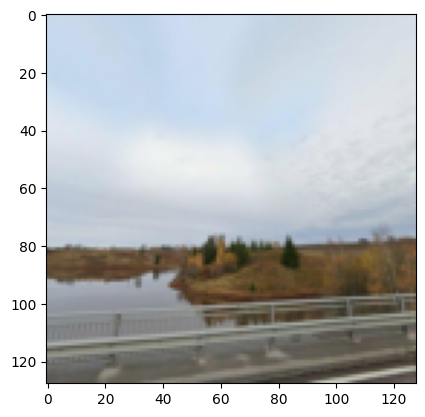

In [151]:
img, data = test_data[random.randint(0, len(test_data)-1)]
print(data)
#from PIL import Image
#load image from test_images
#img = tf(Image.open('./data/test_images/10.png').convert('RGB'))
img = img.to(device)#, torch.tensor(coords).to(device).float()
#print(coords)
plot_img(img.cpu())
img = norm_tf(img)

In [152]:
from pyproj import Proj, transform
import geopy.distance
import warnings
warnings.filterwarnings("ignore")

In [153]:
from pyproj import Proj, transform
import geopy.distance
import warnings
warnings.filterwarnings("ignore")

n_list = pd.read_csv('data/NSVD/n_list.csv')

gps = Proj(init='epsg:4326')
zone34N = Proj(init='epsg:23034')
def weighted_centroid(points, weights):
    res = points
    while len(res) > 1:
        new_res = []
        new_weights = []
        for i in range(0,len(res),2):
            if i+1 == len(res):
              continue
            p1 = res[i]
            p2 = res[i+1]
            w1 = weights[i]
            w2 = weights[i+1]
            
            vector = np.array(p2) - np.array(p1)
            #length = np.linalg.norm(vector)
            
            percentage = w1 / (w1 + w2)
            p = p1 + percentage*vector

            new_res.append(p)
            new_weights.append(w1 + w2)
        res = new_res
        weights = new_weights
    return res

def centroid(points, weights=None):
  weights = np.ones(len(points)) if weights is None else weights
  #If list of strings
  #Make list of string containing a float tuple into float tuples
  if type(points[0]) == str:
    points = [tuple(map(float, point[1:-1].split(','))) for point in points]

  x = [p[0]*weights[i] for i, p in enumerate(points)]
  y = [p[1]*weights[i] for i, p in enumerate(points)]
  centroid = (sum(x) / len(points), sum(y) / len(points))

  print("centroid", centroid)
  return centroid

def distance_from_point_(y, data): 
  BOX_INDEXES = [61, 18, 9, 35, 19, 43, 17, 44, 25, 62, 52, 27, 26, 10, 34, 60, 36]
  #Get percentage of each box
  print("y", torch.softmax(y, dim=0).numpy())
  
  amt = 1
  y_ = y.topk(amt, dim=0)[1]
  
  lat, lng = data['lat'], data['lng']
  # Get y_ to the cpu
  y_ = y_.cpu().numpy()
  # Get the box cords for each of the four best y values
  box_cords = n_list.iloc[[BOX_INDEXES[y_[i]] for i in range(len(y_))]]
  print("Box cords", box_cords)
  box_centers = []
  for i, row in box_cords.iterrows():
    box_centers.append(centroid([row['1'], row['0']]))

  #print(torch.softmax(y[i], dim=0).detach().cpu().numpy())
  percentages =  torch.softmax(y, dim=0).detach().cpu().numpy()
  #get percentage of each box selected
  percentages = percentages[[y_[idx] for idx in range(len(y_))]]
  #calculate new percentages so that they add up to 1
  percentages = percentages / percentages.sum()
  print(sum(torch.softmax(y, dim=0).numpy()))
  estimated_point = weighted_centroid(box_centers, torch.softmax(y, dim=0).numpy())[0]
  print("estimated_point", estimated_point)
  esitmated_point = transform(zone34N, gps, estimated_point[0], estimated_point[1])
  estimated_point = (esitmated_point[1], esitmated_point[0])
  return geopy.distance.geodesic((lat, lng), estimated_point).km, estimated_point

In [154]:
model = torch.load('./data/norwai_zone')
model.to(device)
model.eval()

with torch.no_grad():
    guess = model(img.unsqueeze(0)).flatten()
    lat, lng = data['lat'], data['lng']
    dict = {}
    dict['lat'] = lat
    dict['lng'] = lng
     
    dist, estimated = distance_from_point_(guess.cpu(), dict)

print(dist)
print(estimated)
    

y [0.06191887 0.06337332 0.05265262 0.06607987 0.05611939 0.06318223
 0.0600188  0.06572738 0.05614905 0.05275567 0.05573376 0.06452386
 0.05738485 0.04956637 0.05561299 0.05471097 0.06449003]
Box cords                                    0                                 1
35  (139349.78999999998, 7221187.79)  (-60650.21000000002, 7021187.79)
centroid (39349.78999999998, 7121187.79)
1.0000000186264515
estimated_point (39349.78999999998, 7121187.79)
416.8616314248402
(63.90915425981591, 11.585336106083757)


In [155]:
test = transform(zone34N, gps, -560650.21, 6521187.79)
test

(3.145687009037509, 57.55989425034869)

In [156]:
print(data['lat'], data['lng'])

60.16899872 11.479994


In [157]:
m = folium.Map((64.9701, 13.509217), zoom_start=4)

folium.CircleMarker(location=(data['lat'], data['lng']),tooltip='real', radius=5, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(m)
folium.CircleMarker(location=estimated, radius=5, tooltip='estimated', color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(m)
folium.CircleMarker(location=(test[1], test[0]), radius=10, color='orange', fill=True, fill_color='blue', fill_opacity=1).add_to(m)
folium.PolyLine(locations=[(data['lat'], data['lng']), estimated], color='blue').add_to(m)

m

In [158]:
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
  
from nsvd import NSVD_Boxes, NSVD3

In [159]:
test = NSVD_Boxes('./data', train=False, transforms=tf)
test_ldr = DataLoader(test, batch_size=32, shuffle=True, num_workers=4)

In [160]:
#read n_list from n_list.csv
n_list = pd.read_csv('data/NSVD/n_list.csv')

gps = Proj(init='epsg:4326')
zone34N = Proj(init='epsg:23034')

def weighted_centroid(points, weights):
    res = points
    while len(res) > 1:
        new_res = []
        new_weights = []
        for i in range(0,len(res),2):
            if i+1 == len(res):
              continue
            p1 = res[i]
            p2 = res[i+1]
            w1 = weights[i]
            w2 = weights[i+1]
            
            vector = np.array(p2) - np.array(p1)
            #length = np.linalg.norm(vector)
            
            percentage = w1 / (w1 + w2)
            p = p1 + percentage*vector

            new_res.append(p)
            new_weights.append(w1 + w2)
        res = new_res
        weights = new_weights
    return res

def centroid(points):
  #If list of strings
  #Make list of string containing a float tuple into float tuples
  if type(points[0]) == str:
    points = [tuple(map(float, point[1:-1].split(','))) for point in points]

  x = [p[0] for p in points]
  y = [p[1] for p in points]
  centroid = (sum(x) / len(points), sum(y) / len(points))
  return centroid

def distance_from_point(y, labels, amt = 1): 
  #grad_fn = y.grad_fn
  dist = []
  BOX_INDEXES = [61, 18, 9, 35, 19, 43, 17, 44, 25, 62, 52, 27, 26, 10, 34, 60, 36]
  #print(len(y))
  for i in range(len(y)):
    #Calculate the amt of boxes that need to be selected to reach the percentage requirement
    #amt = 1
    #while sum(torch.softmax(y[i], dim=0).cpu().numpy()[:amt]) < percentage_requirement:
    #  amt += 1
    # Get the four best y values with in each batch
    y_ = y[i].topk(amt, dim=0)[1]
    lat, lng = labels["lat"][i], labels["lng"][i]
    # Get y_ to the cpu
    y_ = y_.cpu().numpy()
    # Get the box cords for each of the four best y values
    box_cords = n_list.iloc[[BOX_INDEXES[y_[idx]] for idx in range(len(y_))]]
  
    box_centers = []
    for _, row in box_cords.iterrows():
      box_centers.append(centroid([row['1'], row['0']]))
    
    #print(torch.softmax(y[i], dim=0).detach().cpu().numpy())
    percentages =  torch.softmax(y[i], dim=0).detach().cpu().numpy()
    #get percentage of each box selected
    percentages = percentages[[y_[idx] for idx in range(len(y_))]]
    #calculate new percentages so that they add up to 1
    percentages = percentages / percentages.sum()

    estimated_point = weighted_centroid(box_centers,percentages)[0]
    #print(estimated_point)
    esitmated_point = transform(zone34N, gps, estimated_point[0], estimated_point[1])
    estimated_point = (esitmated_point[1], esitmated_point[0])
    #y[i] = geopy.distance.distance(estimated_point, (lat, lng)).km
    dist.append(geopy.distance.geodesic((lat, lng), estimated_point).km)

  #res = torch.mean(torch.tensor(dist))#.to(device)
  #res.grad_fn = grad_fn
  return dist

In [161]:
# Testing best amt
losses = []
accs = []
BOX_INDEXES = [61, 18, 9, 35, 19, 43, 17, 44, 25, 62, 52, 27, 26, 10, 34, 60, 36]

#space = np.linspace(0,1, 20)

with torch.no_grad():
    
    for i in range(1,17):
        epoch_acc = 0
        pbar = trange(len(test_ldr), ascii=True)
        for batch_idx, (batch, labels) in enumerate(test_ldr):
            batch, labels = batch.to(device), labels
            y = model(batch)
            
            avd_dist = distance_from_point(y, labels, i)
            
            epoch_acc += np.mean(avd_dist)
            pbar.set_description("test:  amt: {:.2f};  acc: {:.5f}".format(i, (epoch_acc/(batch_idx + 1))))
            pbar.update()
        accs.append(epoch_acc)
        pbar.close()

test:  amt: 16.00;  acc: 441.91677: 100%|##########| 21/21 [00:42<00:00,  2.03s/it]
